<a href="https://colab.research.google.com/github/zzhining/financial_data_analysis/blob/main/stock_hybrid_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 주가 종가 예측 #

2014년부터 2024년까지의 애플(AAPL)의 주가에 대한 데이터로, 과거의 데이터를 통해 미래의 주가를 예측하는 모델을 생성하겠습니다.

In [1]:
!git clone https://github.com/zzhining/time_series_basic.git

Cloning into 'time_series_basic'...
remote: Enumerating objects: 88, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 88 (delta 31), reused 17 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (88/88), 4.61 MiB | 6.24 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [2]:
pip install -U finance-datareader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.3/89.3 kB 2.2 MB/s eta 0:00:00


### 1. 데이터 불러오기

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
import time_series_basic.util as util
import FinanceDataReader as fdr

# retail = pd.read_csv("./time_series_basic/dataset/us-retail-sales.csv", usecols=['Month', 'FoodAndBeverage'],
#     parse_dates=['Month'], index_col='Month').to_period('D')
# retail.head()
df = fdr.DataReader('AAPL', '2014-01-01', '2024-10-31')

In [5]:
df.tail()

,Open,High,Low,Close,Volume,Adj Close
2024-10-24,229.979996,230.820007,228.410004,230.570007,31109500,230.570007
2024-10-25,229.740005,233.220001,229.570007,231.410004,38802300,231.410004
2024-10-28,233.320007,234.729996,232.550003,233.399994,36087100,233.399994
2024-10-29,233.100006,234.330002,232.320007,233.669998,35417200,233.669998
2024-10-30,232.610001,233.470001,229.550003,230.100006,46951400,230.100006


## 모델 1 - 선형회귀

시계열 데이터의 트렌드 속성을 분석하여, 선형회귀 모델을 사용하여 트렌드를 예측하는 모델을 생성

### 2. 데이터 전처리

<Axes: >

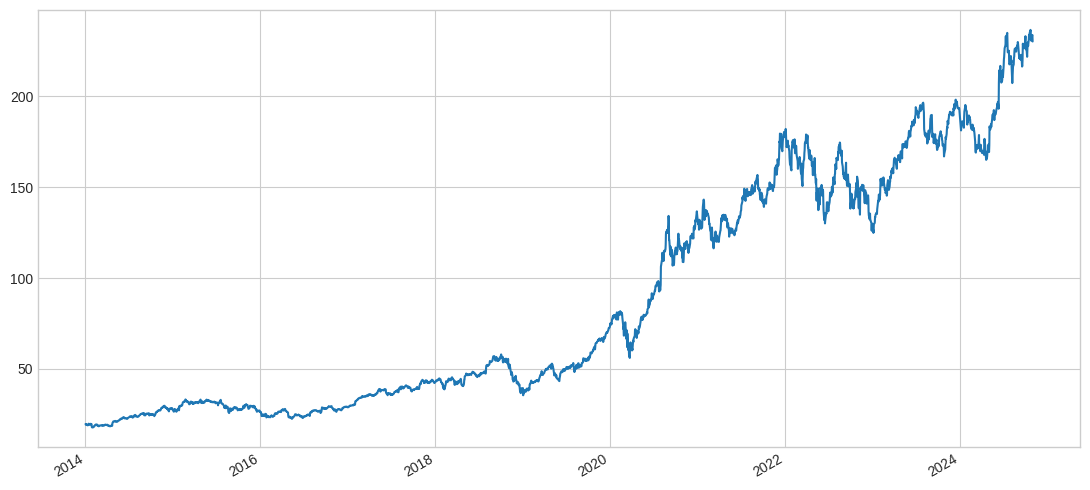

In [6]:
# 예측하고자 하는 값(종속변수), 종가(Close)
y = df['Close'].copy()

# 그래프 생성을 위한 환경 설정(크기, 폰트 등등)
util.init_plt()

# 시각화 - 선 그래프
y.plot()

포물선을 띄는 형태로 증가하고 있으므로, 2차원의 트렌드 변수를 생성합니다.

In [7]:
dp = DeterministicProcess(index=y.index, constant=True, order=2 , drop=True)
X = dp.in_sample()
X.head()

,const,trend,trend_squared
2014-01-02,1.0,1.0,1.0
2014-01-03,1.0,2.0,4.0
2014-01-06,1.0,3.0,9.0
2014-01-07,1.0,4.0,16.0
2014-01-08,1.0,5.0,25.0


**데이터 분할**


최근 30일치 데이터(24년 10월)를 테스트용으로 설정합니다.

인덱스를 기준으로 분할하고, 해당 인덱스에 해당하는 값을 학습용 데이터와 테스트용 데이터로 설정합니다.

In [8]:
idx_train, idx_test = train_test_split(y.index, test_size=30, shuffle=False) # 시계열 데이터를 분할하므로, shuffle을 하지 않을 것!
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

### 3. 학습 - 선형회귀

In [9]:
model = LinearRegression(fit_intercept=False)
model.fit(X_train, y_train)

LinearRegression(fit_intercept=False)

### 4. 예측

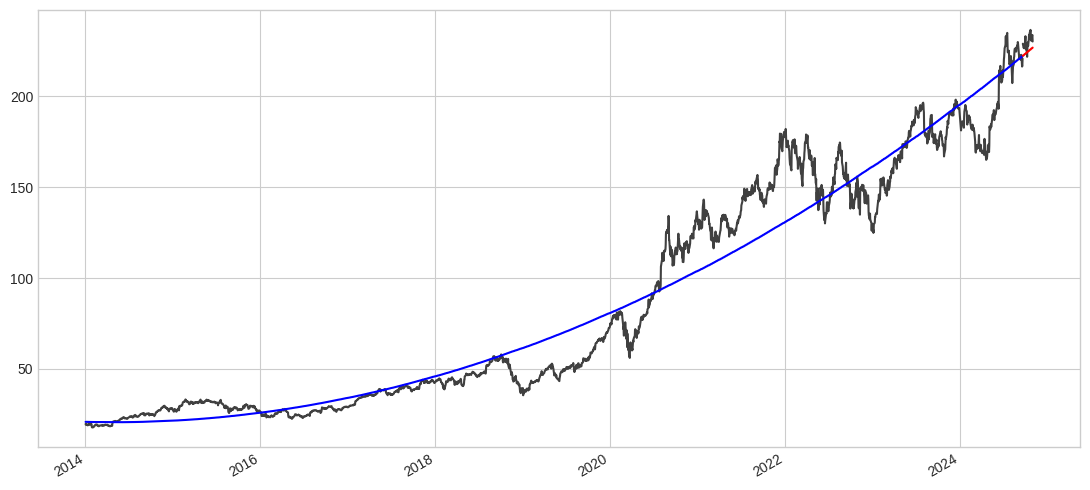

In [12]:
y_fit = pd.DataFrame(model.predict(X_train), index=y_train.index, columns=['Close'])
y_pred = pd.DataFrame(model.predict(X_test), index=y_test.index, columns=['Close'])

axs = y_train.plot(color='0.25', subplots=True, sharex=True, legend=False)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_fit.plot(color='blue', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_pred.plot(color='red', subplots=True, sharex=True, legend=False, ax=axs)

## 모델 2 - XGBoost

XGBoostRegressor를 사용하여 계절성을 예측하는 모델을 생성합니다. <br>
⚠주의⚠ : 주가 데이터는 계절성이 뚜렷하지 않은 데이터임

- `X`: 계절성 주기(예. 월, 요일, 주 등)
- `y`: 종가 - 선형회귀모델(트렌드를 예측한 값)

### 2. 데이터 전처리

In [17]:
X = df.copy()
X["Month"] = X.index.month # 계절성의 주기를 '월' 단위로 봤음
X.head()

,Open,High,Low,Close,Volume,Adj Close,Month
2014-01-02,19.845715,19.893929,19.715000,19.754642,234684800,17.253252,1
2014-01-03,19.745001,19.775000,19.301071,19.320715,392467600,16.874271,1
2014-01-06,19.194643,19.528570,19.057142,19.426071,412610800,16.966299,1
2014-01-07,19.440001,19.498571,19.211430,19.287144,317209200,16.844954,1
2014-01-08,19.243214,19.484285,19.238930,19.409286,258529600,16.951633,1


In [18]:
# 종속변수, 독립변수 할당
y = X['Close']
X = X['Month']

In [19]:
# 데이터 분할
X_train, X_test = X.loc[idx_train], X.loc[idx_test]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

<Axes: >

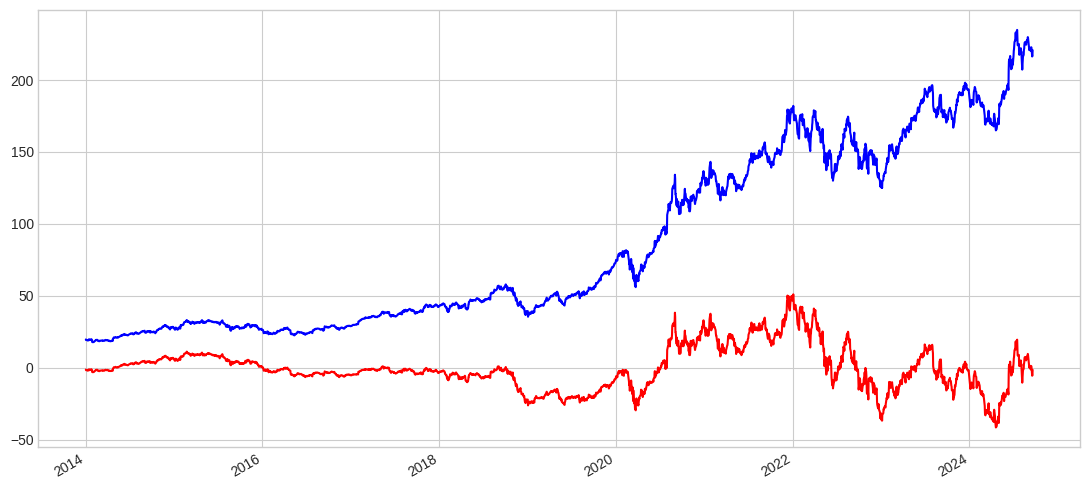

In [20]:
# 종속변수(타겟변수)를 y_train(실제값)에서 선형회귀에서 학습한 부분(y_fit)을 제외한 값으로 설정
y_resid = y_train - y_fit['Close']
y_train.plot(color = 'blue')
y_resid.plot(color = 'red')

### 3. 학습 - XGBoost

In [21]:
xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

### 4. 예측

- 선형회귀모델로 만든 결과(트렌드 예측) + XGB로 예측한 결과(계절성 예측)

In [22]:
y_fit_boosted = xgb.predict(X_train) + y_fit['Close'] # 계절성 + 트렌드
y_pred_boosted = xgb.predict(X_test) + y_pred['Close']

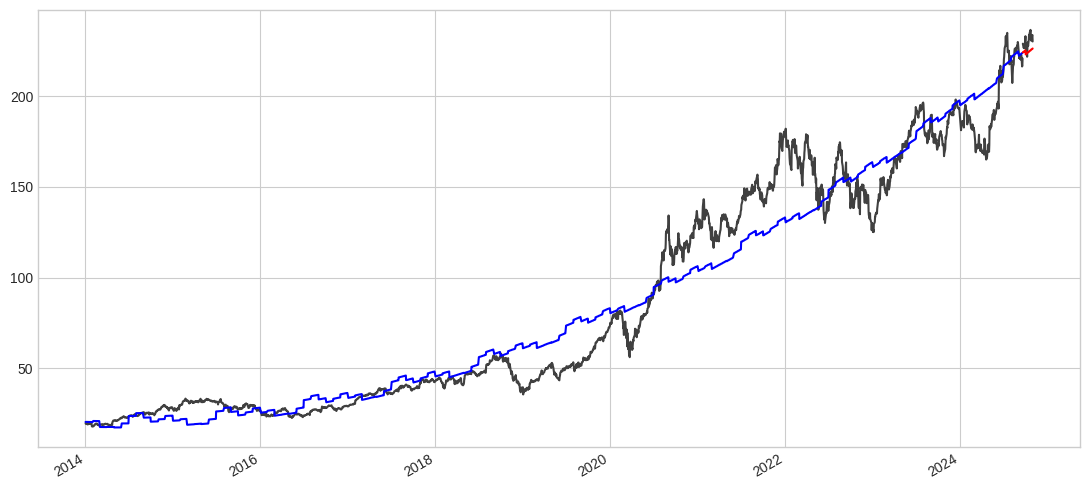

In [23]:
axs = y_train.plot(color='0.25', subplots=True, sharex=True, legend=False)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_fit_boosted.plot(color='blue', subplots=True, sharex=True, legend=False, ax=axs)
axs = y_pred_boosted.plot(color='red', subplots=True, sharex=True, legend=False, ax=axs)